# 합성곱 신경망 - CNN(Convolutional Neural Network)

---

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

plt.rc('figure', figsize=(10, 6))

from matplotlib import rcParams
rcParams['font.family'] = 'New Gulim'
rcParams['font.size'] = 10
rcParams['axes.unicode_minus'] = False

# 1 CNN 전체 구조
- 합성곱 계층(Convolutional Layer)
- 풀링 계층(Pooling Layer)
- 완전 연결 계층(Fully Connected Layer) - Affine 계층
- ReLU 계층(ReLU Layer)
- 소프트맥스 계층(Softmax Layer)

- 완전 연결 계층(Affine 계층)으로 이루어진 네트워크
<img src="./images/fig_7-1.png" width="600"/>

- CNN으로 이루어진 네트워크: 합성곱 계층과 풀링 계층이 추가
<img src="./images/fig_7-2.png" width="600"/>

# 2 합성곱 계층 - Convolutional Layer

### 2.1 합성곱 연산

- 합성곱 연산의 예
<img src="./images/fig_7-3.png" width="500"/>

- 합성곱 연산의 계산 순서
<img src="./images/fig_7-4.png" width="400"/>

- 합성곱 연산의 편향: 필터를 적용한 원소에 고정값(편향)을 더한다
<img src="./images/fig_7-5.png" width="600"/>

### 2.2 패딩 - padding

- 합성곱 연산의 패딩 처리: 입력 데이터 주위에 0을 채운다(점선 영역)
<img src="./images/fig_7-6.png" width="500"/>

### 2.3 스트라이드 - stride (Step size)

- 스트라이드가 2인 합성곱 연산
<img src="./images/fig_7-7.png" width="500"/>

- 출력 크기 계산
- 입력 크기(H, W), 필터 크기(FH, FW), 출력 크기(OH, OW)
<img src="./images/e_7.1.png" width="200"/>

- 출력 크기 계산 예제
<img src="./images/fig_7-7-1.png" width="400"/>

### 2.4 3차원 데이터의 합성곱 연산

- 3차원 데이터 합성곱 연산의 예
<img src="./images/fig_7-8.png" width="500"/>

- 3차원 데이터 합성곱 연산의 계산 순서
<img src="./images/fig_7-9.png" width="400"/>

### 2.5 블록으로 표현

- 합성곱 연산으로 블록으로 표현
<img src="./images/fig_7-10.png" width="500"/>

- 여러 필터를 사용한 합성곱 연산의 예: 출력이 다수의 채널로 생성
<img src="./images/fig_7-11.png" width="500"/>

- 합성곱 연산의 처리 흐름(편향 추가)
<img src="./images/fig_7-12.png" width="600"/>

### 2.6 배치 처리

- 합성곱 연산의 처리 흐름(배치 처리)
<img src="./images/fig_7-13.png" width="600"/>

# 3 풀링 계층 - Pooling Layer

- 최대 풀링(Max Pooling)의 처리 순서
<img src="./images/fig_7-14.png" width="600"/>

### 3.1 풀링 계층의 특징

- 풀링 윈도우 크기와 스트라이드는 동일하게 설정한다
- 학습해야 할 매개변수가 없다(필터 없음)
- 채널 수가 변하지 않는다
- 입력의 변화에 영향을 적게 받는다(강건하다)

- 풀링은 채널 수를 바꾸지 않는다
<img src="./images/fig_7-15.png" width="400"/>

- 입력 데이터가 가로로 1원소만큰 어긋나도 출력은 같다
<img src="./images/fig_7-16.png" width="600"/>

# 4 합성곱/풀링 계층 구현

### 4.1 CNN(4차원 데이터)
- (N, C, H, W)
- (데이터수, 채널수, 높이, 너비)

### 4.2 데이터 전개 - im2col 트릭 사용

- 4차원 데이터를 2차원 데이터로 변환

- im2col의 동작
<img src="./images/fig_7-17.png" width="400"/>

- 필터 적용 영역을 앞에서부터 순서대로 1줄로 펼친다
<img src="./images/fig_7-18.png" width="400"/>

- 합성곱 연산의 필터 처리 과정
<img src="./images/fig_7-19.png" width="500"/>

### 4.3 합성곱 계층 구현

#### 4.3.1 im2col 함수 사용 예제

##### im2col(input_data, filter_h, filter_w, stride=1, pad=0)
- input_data - (데이터수, 채널수, 높이, 너비)의 4차원 배열
- filter_h - 필터의 높이
- filter_w - 필터의 너비
- stride - 스트라이드
- pad - 패팅

In [ ]:
from common.util import im2col

x1 =  np.random.rand(1, 3, 7, 7) # (데이터수/ 채널수/ 높이/ 너비)
col1 = im2col(x1, 5, 5, stride=1, pad=0)
print(col1.shape) # (9, 75)

x2 = np.random.rand(10, 3, 7, 7) # 데이터 10개
col2 = im2col(x2, 5, 5, stride=1, pad=0)
print(col2.shape) # (90, 75)

(9, 75)
(90, 75)


#### 4.3.2 합성곱 계층 코드 구현

- 축 순서 변경: numpy.transpose() 사용
<img src="./images/fig_7-20.png" width="500"/>

In [ ]:
# 합성곱 계층 코드 구현

class Convolution:
    def __init__(self, W, b, stride=1, pad=0):
        self.W = W
        self.b = b
        self.stride = stride
        self.pad = pad

    def forward(self, x):
        FN, C, FH, FW = self.W.shape
        N, C, H, W = x.shape
        out_h = int(1 + (H + 2*self.pad - FH) / self.stride)
        out_w = int(1 + (W + 2*self.pad - FW) / self.stride)

        col = im2col(x, FH, FW, self.stride, self.pad)
        col_W = self.W.reshape(FN, -1).T # 필터 전개
        out = np.dot(col, col_W) + self.b

        out = out.reshape(N, out_h, out_w, -1).transpose(0, 3, 1, 2)

        return out

### 4.4 풀링 계층 구현

- 입력 데이터에 풀링 적용 영역을 전개(2X2 풀링의 예)
<img src="./images/fig_7-21.png" width="400"/>

- 풀링 계층 구현의 흐름: 풀링 적용 영역에서 가장 큰 원소는 회색으로 표시
<img src="./images/fig_7-22.png" width="600"/>

In [ ]:
# 풀링 계층 코드 구현

class Pooling:
    def __init__(self, pool_h, pool_w, stride=1, pad=0):
        self.pool_h = pool_h
        self.pool_w = pool_w
        self.stride = stride
        self.pad = pad

    def forward(self, x):
        N, C, H, W = x.shape
        out_h = int(1 + (H - self.pool_h) / self.stride)
        out_w = int(1 + (W - self.pool_w) / self.stride)

        # 전개(1)
        col = im2col(x, self.pool_h, self.pool_w, self.stride, self.pad)
        col = col.reshape(-1, self.pool_h*self.pool_w)

        # 최대값(2)
        out = np.max(col, axis=1)

        # 성형(3)
        out = out.reshape(N, out_h, out_w, C).transpose(0, 3, 1, 2)

        return out

# 5 CNN 구현

### 5.1 CNN class 코드 구현

- 단순한 CNN 네트워크 구성
<img src="./images/fig_7-23.png" width="600"/>

##### SimpleConvNet() 생성시 입력 변수
- input_dim - 입력 데이터(채널수, 높이, 너비)의 차원
- conv_param - 합성곱 계층의 하이퍼파라미터(딕셔너리). 딕셔너리의 키는 다음과 같다
 - filter_num - 필터수
 - filter_size - 필터크기
 - stride - 스트라이드
 - pad - 패딩
- hidden_size - 은닉층(완전연결)의 뉴런수
- output_size - 출력층(완전연결)의 뉴런수
- weight_init_std - 초기화 때의 가중치 표준편차

In [ ]:
# SimpleConvNet() 코드 구현

import pickle
from collections import OrderedDict
from common.layers import *
from common.gradient import numerical_gradient

class SimpleConvNet:
    """단순한 합성곱 신경망

    conv - relu - pool - affine - relu - affine - softmax

    Parameters
    ----------
    input_size : 입력 크기（MNIST의 경우엔 784）
    hidden_size_list : 각 은닉층의 뉴런 수를 담은 리스트（e.g. [100, 100, 100]）
    output_size : 출력 크기（MNIST의 경우엔 10）
    activation : 활성화 함수 - 'relu' 혹은 'sigmoid'
    weight_init_std : 가중치의 표준편차 지정（e.g. 0.01）
        'relu'나 'he'로 지정하면 'He 초깃값'으로 설정
        'sigmoid'나 'xavier'로 지정하면 'Xavier 초깃값'으로 설정
    """
    def __init__(self, input_dim=(1, 28, 28),
                 conv_param={'filter_num':30, 'filter_size':5, 'pad':0, 'stride':1},
                 hidden_size=100, output_size=10, weight_init_std=0.01):
        filter_num = conv_param['filter_num']
        filter_size = conv_param['filter_size']
        filter_pad = conv_param['pad']
        filter_stride = conv_param['stride']
        input_size = input_dim[1]
        conv_output_size = (input_size - filter_size + 2*filter_pad) / filter_stride + 1
        pool_output_size = int(filter_num * (conv_output_size/2) * (conv_output_size/2))

        # 가중치 초기화
        self.params = {}
        self.params['W1'] = weight_init_std * \
                            np.random.randn(filter_num, input_dim[0], filter_size, filter_size)
        self.params['b1'] = np.zeros(filter_num)
        self.params['W2'] = weight_init_std * \
                            np.random.randn(pool_output_size, hidden_size)
        self.params['b2'] = np.zeros(hidden_size)
        self.params['W3'] = weight_init_std * \
                            np.random.randn(hidden_size, output_size)
        self.params['b3'] = np.zeros(output_size)

        # 계층 생성
        self.layers = OrderedDict()
        self.layers['Conv1'] = Convolution(self.params['W1'], self.params['b1'],
                                           conv_param['stride'], conv_param['pad'])
        self.layers['Relu1'] = Relu()
        self.layers['Pool1'] = Pooling(pool_h=2, pool_w=2, stride=2)
        self.layers['Affine1'] = Affine(self.params['W2'], self.params['b2'])
        self.layers['Relu2'] = Relu()
        self.layers['Affine2'] = Affine(self.params['W3'], self.params['b3'])

        self.last_layer = SoftmaxWithLoss()

    def predict(self, x):
        for layer in self.layers.values():
            x = layer.forward(x)

        return x

    def loss(self, x, t):
        """손실 함수를 구한다.

        Parameters
        ----------
        x : 입력 데이터
        t : 정답 레이블
        """
        y = self.predict(x)
        return self.last_layer.forward(y, t)

    def accuracy(self, x, t, batch_size=100):
        if t.ndim != 1 : t = np.argmax(t, axis=1)

        acc = 0.0

        for i in range(int(x.shape[0] / batch_size)):
            tx = x[i*batch_size:(i+1)*batch_size]
            tt = t[i*batch_size:(i+1)*batch_size]
            y = self.predict(tx)
            y = np.argmax(y, axis=1)
            acc += np.sum(y == tt)

        return acc / x.shape[0]

    def numerical_gradient(self, x, t):
        """기울기를 구한다（수치미분）.

        Parameters
        ----------
        x : 입력 데이터
        t : 정답 레이블

        Returns
        -------
        각 층의 기울기를 담은 사전(dictionary) 변수
            grads['W1']、grads['W2']、... 각 층의 가중치
            grads['b1']、grads['b2']、... 각 층의 편향
        """
        loss_w = lambda w: self.loss(x, t)

        grads = {}
        for idx in (1, 2, 3):
            grads['W' + str(idx)] = numerical_gradient(loss_w, self.params['W' + str(idx)])
            grads['b' + str(idx)] = numerical_gradient(loss_w, self.params['b' + str(idx)])

        return grads

    def gradient(self, x, t):
        """기울기를 구한다(오차역전파법).

        Parameters
        ----------
        x : 입력 데이터
        t : 정답 레이블

        Returns
        -------
        각 층의 기울기를 담은 사전(dictionary) 변수
            grads['W1']、grads['W2']、... 각 층의 가중치
            grads['b1']、grads['b2']、... 각 층의 편향
        """
        # forward
        self.loss(x, t)

        # backward
        dout = 1
        dout = self.last_layer.backward(dout)

        layers = list(self.layers.values())
        layers.reverse()
        for layer in layers:
            dout = layer.backward(dout)

        # 결과 저장
        grads = {}
        grads['W1'], grads['b1'] = self.layers['Conv1'].dW, self.layers['Conv1'].db
        grads['W2'], grads['b2'] = self.layers['Affine1'].dW, self.layers['Affine1'].db
        grads['W3'], grads['b3'] = self.layers['Affine2'].dW, self.layers['Affine2'].db

        return grads

    def save_params(self, file_name="params.pkl"):
        params = {}
        for key, val in self.params.items():
            params[key] = val
        with open(file_name, 'wb') as f:
            pickle.dump(params, f)

    def load_params(self, file_name="params.pkl"):
        with open(file_name, 'rb') as f:
            params = pickle.load(f)
        for key, val in params.items():
            self.params[key] = val

        for i, key in enumerate(['Conv1', 'Affine1', 'Affine2']):
            self.layers[key].W = self.params['W' + str(i+1)]
            self.layers[key].b = self.params['b' + str(i+1)]

### 5.2 MNIST 데이터 학습 - SimpleConvNet() 사용

In [ ]:
%%time

from dataset.mnist import load_mnist
from common.trainer import Trainer

# 데이터 읽기
(x_train, t_train), (x_test, t_test) = load_mnist(flatten=False)

# 시간이 오래 걸릴 경우 데이터를 줄인다.
x_train, t_train = x_train[:5000], t_train[:5000]
x_test, t_test = x_test[:1000], t_test[:1000]

# 시간이 오래 걸릴 경우 max_epochs를 줄인다.
#max_epochs = 5
max_epochs = 20

network = SimpleConvNet(input_dim=(1,28,28),
                        conv_param = {'filter_num': 30, 'filter_size': 5, 'pad': 0, 'stride': 1},
                        hidden_size=100, output_size=10, weight_init_std=0.01)

trainer = Trainer(network, x_train, t_train, x_test, t_test,
                  epochs=max_epochs, mini_batch_size=100,
                  optimizer='Adam', optimizer_param={'lr': 0.001},
                  evaluate_sample_num_per_epoch=1000)
trainer.train()

# 매개변수 보존
network.save_params('data/params.pkl')
print('Saved Network Parameters!')

train loss:2.299981339953659
=== epoch:1, train acc:0.124, test acc:0.114 ===
train loss:2.2979402928807517
train loss:2.296289307433726
train loss:2.2931483408744064
train loss:2.287580919076729
train loss:2.2760334768404054
train loss:2.269948784819183
train loss:2.250412916769473
train loss:2.207935624199849
train loss:2.222518932186632
train loss:2.1790013136123956
train loss:2.1503375473780193
train loss:2.083487684187597
train loss:2.1108599574439055
train loss:2.041786541962836
train loss:1.929115026870073
train loss:1.9205521863039234
train loss:1.8388872932318439
train loss:1.8633322654608244
train loss:1.7217939149018784
train loss:1.5570008839165324
train loss:1.6391235962217414
train loss:1.4969504313600224
train loss:1.4526002809230938
train loss:1.3411988896140457
train loss:1.4085197452276446
train loss:1.2319513151114052
train loss:1.0732068506346288
train loss:1.134288595453658
train loss:1.0410321130577782
train loss:0.9704319183868616
train loss:1.0114541371335384
tr

train loss:0.09959857347387746
train loss:0.29399619528785637
train loss:0.1779227990673944
train loss:0.2004559915770996
train loss:0.2554129865197379
train loss:0.16948254850742153
train loss:0.17890108833485655
train loss:0.1292136148703043
train loss:0.12293079042870297
train loss:0.2036553945299239
train loss:0.19062031924759984
train loss:0.14995920311719957
train loss:0.19921696706927008
train loss:0.1075164016348809
train loss:0.235487240223348
train loss:0.24652529113253427
train loss:0.2096984452437715
train loss:0.18576294782720776
train loss:0.12070605581730268
train loss:0.1631144744732304
train loss:0.1813286415613945
train loss:0.20673795089510358
train loss:0.13427336499115974
train loss:0.2824418850887634
train loss:0.15788606082521928
train loss:0.13228890158499032
train loss:0.19265576122672953
train loss:0.19178219372429264
train loss:0.14934399426070835
train loss:0.20876006140882858
train loss:0.2026919606919005
train loss:0.10735839706139988
train loss:0.10165500

train loss:0.12410628594230502
train loss:0.04364848796657154
train loss:0.06045452639899297
train loss:0.0729758548836314
train loss:0.08010586094533628
train loss:0.02282407413653395
train loss:0.08068907007547681
train loss:0.08646551679694657
train loss:0.07820746982563974
train loss:0.03169668933510316
train loss:0.07339764159375416
train loss:0.10073784262953023
train loss:0.06557833547893237
train loss:0.049120641373534724
train loss:0.03127077354239691
train loss:0.05003661574717017
train loss:0.03927498643379313
train loss:0.0609360191293498
train loss:0.06088951553401992
train loss:0.05675980265517346
train loss:0.06680168619443644
train loss:0.06167457557263365
train loss:0.07173722439458047
train loss:0.07485653978902373
train loss:0.03779473081695086
train loss:0.030708918757372503
train loss:0.06674374540418826
train loss:0.14431854106269937
train loss:0.05189277137128454
train loss:0.0903844922398741
train loss:0.039586828351334785
train loss:0.2587206377140278
=== epoch

train loss:0.02561851533351541
train loss:0.03390784859264482
train loss:0.03169840239211701
train loss:0.0443790785342526
train loss:0.026864379724197897
train loss:0.021572175331317292
train loss:0.03526876533077833
train loss:0.06383778229216493
train loss:0.03742558456000452
train loss:0.02717593441922173
train loss:0.03101887959447753
train loss:0.04354702022188351
train loss:0.05687018739020641
train loss:0.04430090013386872
train loss:0.012962492431208682
train loss:0.03011324415146297
train loss:0.04895843238633651
train loss:0.01399460035596545
train loss:0.013916374093449878
train loss:0.007053199831822906
train loss:0.05057168640279446
train loss:0.03147684682364185
train loss:0.018477858089307953
train loss:0.045206576928771766
train loss:0.039373580407920196
train loss:0.01540307061959606
=== epoch:17, train acc:0.988, test acc:0.962 ===
train loss:0.03419873674602967
train loss:0.010288529277018003
train loss:0.04332881751217292
train loss:0.03643764170601537
train loss:0

findfont: Font family 'New Gulim' not found.
findfont: Font family 'New Gulim' not found.
findfont: Font family 'New Gulim' not found.
findfont: Font family 'New Gulim' not found.
findfont: Font family 'New Gulim' not found.
findfont: Font family 'New Gulim' not found.
findfont: Font family 'New Gulim' not found.
findfont: Font family 'New Gulim' not found.
findfont: Font family 'New Gulim' not found.
findfont: Font family 'New Gulim' not found.
findfont: Font family 'New Gulim' not found.
findfont: Font family 'New Gulim' not found.
findfont: Font family 'New Gulim' not found.
findfont: Font family 'New Gulim' not found.
findfont: Font family 'New Gulim' not found.
findfont: Font family 'New Gulim' not found.
findfont: Font family 'New Gulim' not found.
findfont: Font family 'New Gulim' not found.
findfont: Font family 'New Gulim' not found.
findfont: Font family 'New Gulim' not found.
findfont: Font family 'New Gulim' not found.
findfont: Font family 'New Gulim' not found.
findfont: 

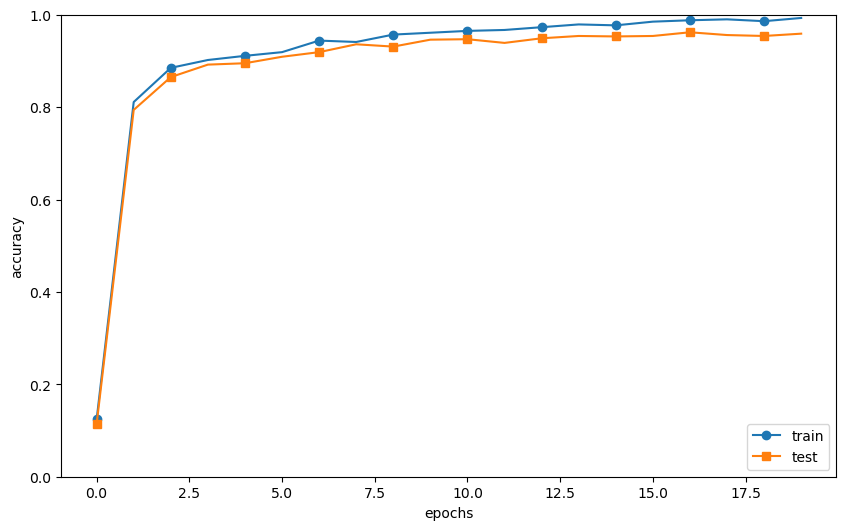

In [ ]:
# 그래프 그리기
markers = {'train': 'o', 'test': 's'}
x = np.arange(max_epochs)
plt.plot(x, trainer.train_acc_list, marker='o', label='train', markevery=2)
plt.plot(x, trainer.test_acc_list, marker='s', label='test', markevery=2)
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.show()

# 6 CNN 시각화

### 6.1 CNN 1번째 층의 가중치 시각화

#####  가중치(필터) 시각화 함수 정의

In [ ]:
# 가중치(필터) 시각화 함수 정의

def filter_show(filters, nx=8, margin=3, scale=10):
    """
    c.f. https://gist.github.com/aidiary/07d530d5e08011832b12#file-draw_weight-py
    """
    FN, C, FH, FW = filters.shape
    ny = int(np.ceil(FN / nx))

    fig = plt.figure(figsize=(10,4))
    fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

    for i in range(FN):
        ax = fig.add_subplot(ny, nx, i+1, xticks=[], yticks=[])
        ax.imshow(filters[i, 0], cmap=plt.cm.gray_r, interpolation='nearest')
    plt.show()

#####  가중치(필터) 시각화: 무작위(랜덤) 초기화 후의 가중치
- filter = (30, 1, 5, 5): 5X5(흑백) 30개의 필터

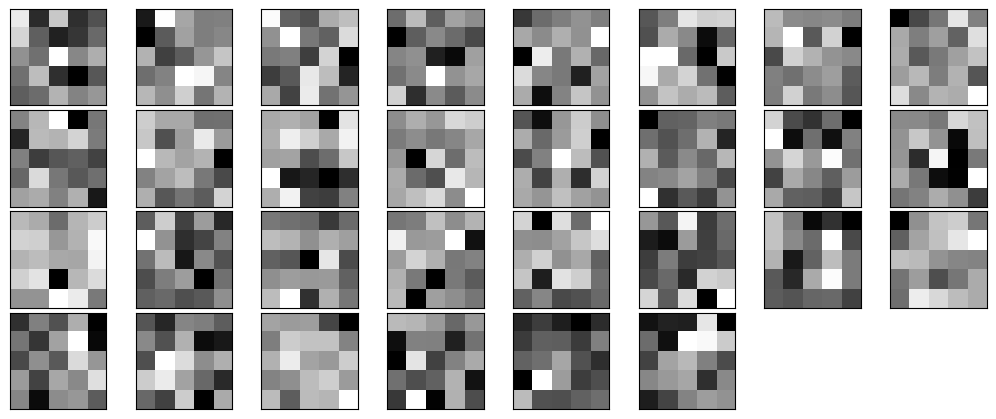

In [ ]:
network_v = SimpleConvNet()

filter_show(network_v.params['W1'])

#####  가중치(필터) 시각화: 학습된 가중치
- filter = (30, 1, 5, 5): 5X5(흑백) 30개의 필터

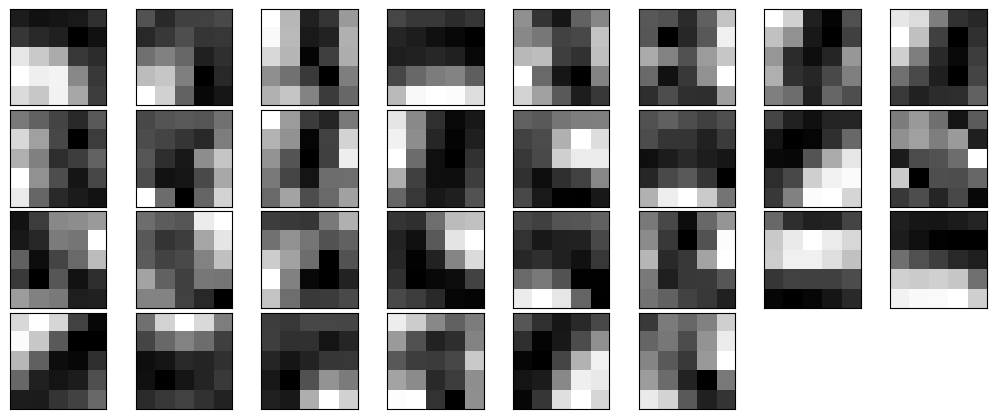

In [ ]:
network_v.load_params('data/params.pkl')

filter_show(network_v.params['W1'])

- 가로 에지와 세로 에지에 반응히는 필터
- 출력 이미지 1 은 세로 에지에 흰 픽셀이 나타나고, 출력 이미지 2 는 가로 에지에 흰 픽셀이 많이 나온다

<img src="./images/fig_7-25.png" width="700"/>

### 6.2 CNN 층 깊이에 따른 추출 정보 변화

- CNN의 합성곱 계층에서 추출되는 정보
 - 1 번째 층은 에지와 블롭
 - 3번째 층은 텍스처
 - 5번째 층은 사물의 일부
 - 마지막 완전연결 계층은 사물의 클래스(개, 자동차등)에 뉴린이 반응한다

<img src="./images/fig_7-26.png" width="700"/>

# 7 대표적인 CNN

### 7.1 LeNet

- 1998년에 제안된 첫번째 CNN
- (합성곱 계층 + 풀링 계층) 반복 + 완전 연결 계층
- 활성화 함수: Sigmoid 함수 사용 vs ReLU
- 풀링: 서브샘플링(단순히 원소의 수를 줄이기만 하는 용도) vs Max Pooling

- LeNet의 구성
<img src="./images/fig_7-27.png" width="700"/>

### 7.2 AlexNet

- 2012년에 제안된 CNN: 딥러닝 열풍의 주역
- (합성곱 계층 + 풀링 계층) 반복 + 완전 연결 계층
- 활성화 함수: ReLU 함수 사용
- 풀링: Max Pooling
- 드롭아웃 사용
- LRN(Local Response Normalization 이라는 국소적 정규화를 실시하는 계층 이용
- 빅데이터와 GPU의 적극적인 활용 가능

- AlexNet의 구성
<img src="./images/fig_7-28.png" width="600"/>

# 정리

- CNN은 지금까지의 완전연결 계층 네트워크에 합성곱 계층과 풀링 계층을 새로 추가한다.
- 합성곱 계층과 풀링 계층은 im2col(이미지를 행렬로 전개하는 함수)을 이용하면 간단하고 효율적으로 구현할수있다.
- CNN을 시각화 해보면 계층이 갚어질수록 고급 정보가 추출되는 모습을 확인할수 있다.
- 대표적인 CNN에는 LeNet과 AlexNet이 있다.
- 답러닝의 발전에는 빅데이터와 GPU가 크게 기여했다.

---

# NOTE

- CNN 구성 요소  
  
  Convolutional Layer  
  Pooling Layer  
  Fully Connected Layer (기존에 쓰던 기본적인 층) - Affine 계층  
  ReLU Layer  
  Softmax Layer    
  
    
- 완전 연결 계층(Affine 계층)으로 이루어진 네트워크
<img src="./images/fig_7-1.png" width="600"/>

- CNN으로 이루어진 네트워크: 합성곱 계층과 풀링 계층이 추가
<img src="./images/fig_7-2.png" width="600"/>
  
---  

* Convolutional Layer  

  4x4 행렬을 2x2로 나타냄.  
  PCA 느낌으로다가 4x4에서 4개의 섹터를 정해서 각각을 Filter와 상호작용을 통해 2x2로 변환함.  
  
  <img src="./images/fig_7-4.png" width="400"/>  
  
  4x4를 한 줄로 풀어서 나타내면 x1, x2, x3, ..., x16인데, 최종 output이 z1, z2, z3, z4이다.  
  filter는 가중치 w를 의미하며, 만일 filter가 3x3이면, x들을 이용해서 z1을 하나 만드는데 9개의 x가 필요하다는 것을 의미한다.  
  예를 들어 첫번째 섹션에서 x들을 뽑아 z1을 만든다고 하면, 1, 2, 3, 5, 6, 7, 9, 10,11의 x가 사용된다.  
  
  z2를 만들 때 사용되는 w들은 z1을 만들 때 사용된 w들과 같다. 가중치는 그대로 적용되고 x값만 바뀐다.  
  z2를 만들 때 x는 2, 3, 4, 6, 7, 8, 10, 11, 12가 사용된다.  
  
  그렇다면? filter(가중치) 중 하나인 w1은 x1에도 사용되고 x2에도 사용되었으며, w2는 x2에도 사용되고 x3에도 사용되고....  
  같은 가중치 세트들이 섹터마다 조금씩 아래로 밀리며 서로 다른 x에 적용되는 셈이다.  
  
---  

* Padding  

  4x4 짜리를 3x3 필터를 거쳐 2x2를 얻는 게 아니라, 4x4 짜리를 얻고 싶다?  
  원본 4x4 겉에 0으로 채워진 패딩을 입혀서 할 수 있다.  

<img src="./images/fig_7-6.png" width="500"/>  

---  

* 3차원 데이터의 합성곱 연산

  3차원 데이터 합성곱 연산의 예
<img src="./images/fig_7-8.png" width="500"/>

<img src="./images/fig_7-9.png" width="400"/>

* 배치

  입력데이터가 N개(배치 수) 들어간다.  
  필터 등 다른 데이터들은 그대로.  
  
  <img src="./images/fig_7-13.png" width="600"/>
  
---
  
  
* Pooling Layer  

  필터 없이 4x4의 각 섹션에서 대표값을 하나씩 뽑아서 2x2로 나타낸다.  
  즉, 이미지를 뭉뚱그려 표현하는 것이 된다.(대표값을 제외한 나머지는 무시하는 거니까)  
  
  기본값으로 각 섹션에서 최대값을 뽑아 사용하는 것을 Max Pooling이라고 한다.  
  <img src="./images/fig_7-14.png" width="600"/>
  
---
  
* 데이터 전개 - im2col 트릭 사용

  4차원 데이터를 2차원 데이터로 변환

  im2col의 동작
<img src="./images/fig_7-17.png" width="400"/>

  필터 적용 영역을 앞에서부터 순서대로 1줄로 펼친다
<img src="./images/fig_7-18.png" width="400"/>

  합성곱 연산의 필터 처리 과정
<img src="./images/fig_7-19.png" width="500"/>

---

## 상단 4, 5의 '구현' 과정과 코드는 확인해 볼 것

In [ ]:
# End of file